# Variational Autoencoder
* paper: [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

## Implementation Details
* **Training Data**: `FGVC-Aircraft`
* **Goal**: Generate Random New Image of Aircraft
* **Encoder Layers**: *in progress*
* **Decoder Layers**: *in progress*

In [ ]:
import torch

# Network

In [171]:
import torch.nn as nn

# TODO: right now sizes hardcoded, need paramters to control dimensions instead
# TODO: experiment in training with different variations of current model

class Encoder(nn.Module):
    def __init__(self, img_channels, latent_dim):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.mu = nn.Linear(64*7*7, latent_dim)
        self.log_sigma = nn.Linear(64*7*7, latent_dim)

    def forward(self, X):
        f = self.f(X)
        mean = self.mu(f.view(-1, 64*7*7))
        log_var = self.log_sigma(f.view(-1, 64*7*7))
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, img_channels, latent_dim):
        super().__init__()
        self.start = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7),
            nn.BatchNorm1d(64*7*7),
            nn.ReLU(),
        )
        self.f = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2),
            nn.LeakyReLU(),
        )
    
    def forward(self, z):
        start = self.start(z)
        out = self.f(start.view(-1, 64, 7, 7))
        return out


class VAE(nn.Module):
    def __init__(self, img_channels):
        super().__init__()
        self.enc = Encoder(img_channels)
        self.dec = Decoder(img_channels)

    def forward(self, X):
        mu, log_sig = self.enc(X)
        z = get_sample(mu, log_sig)
        out = self.dec(z)
        return out, mu, log_sig

# Getting Dataset

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

train = datasets.FGVCAircraft(
    root = 'data',
    split = 'train',
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((64, 64))])
)

test = datasets.FGVCAircraft(
    root = 'data',
    split = 'test',
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((64, 64))])
)

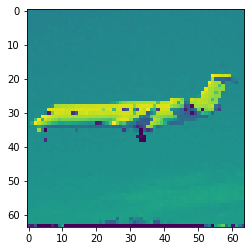

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test[1500][0][0])

In [318]:
from torch.utils.data import DataLoader, Subset

def create_dataloaders(train_data: torch.Tensor, test_data: torch.Tensor, bs: int = 64):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=True)
    return train_loader, test_loader

subset = True
train_loader = None
test_loader = None

# TODO: train using all of training images
# wanna wait until i feel a bit better about core model results
if subset:
    # train and test on small subset of data for now.
    train_ = Subset(train, range(750))
    test_ = Subset(test, range(25))
    train_loader, test_loader = create_dataloaders(train_, test_, bs=256)

else:
    train_loader, test_loader = create_dataloaders(train, test, bs=256)

len(train_loader) * 256

768

# Train

In [231]:
def kl_loss(mean: torch.Tensor, log_var: torch.Tensor):
    # paper uses sum, but wasn't really capturing variance of imgs
    # some things online suggested balacing issue between kl loss and other loss
    
    # using mean seemed to give "better" results. 

    # TODO: investigate the issue mentioned above more
    return -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

In [ ]:
def get_sample(mean: torch.Tensor, log_var: torch.Tensor):
    e = torch.randn_like(mean)
    var = torch.exp(log_var/2)
    return mean + var*e

In [314]:
import torch.optim as optim
from tqdm import tqdm

kl_losses = []
mse_losses = []
vae = VAE(3).to('cuda')

In [262]:
def train_model(model: nn.Module, train_loader: DataLoader, bs: int = 64, epochs: int = 10):
    model.train()
    opt = optim.Adam(vae.parameters(), lr=0.01)
    for i in tqdm(range(epochs)):
        for batch, (X, _) in enumerate(train_loader):
            # train
            opt.zero_grad()

            X = X.to('cuda')

            out, mean, log_var = model(X)

            kl = kl_loss(mean, log_var)
            mse = nn.MSELoss()(out, X)
            loss = kl + mse
            loss.backward()

            kl_losses.append(kl)
            mse_losses.append(mse)

            opt.step()

In [264]:
train_model(vae, train_loader, epochs=100)

100%|██████████| 100/100 [18:04<00:00, 10.85s/it]


In [310]:
torch.save(vae.state_dict(), './model.pth')

# Test

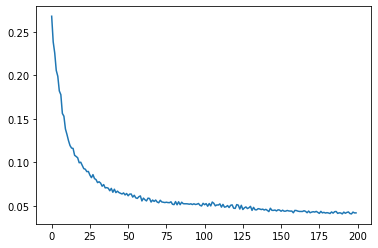

In [261]:
losses = list(map(lambda x: x.cpu().detach().numpy(), mse_losses))
plt.plot(losses)

In [186]:
print(losses)

[array(2050.0422, dtype=float32), array(10886.859, dtype=float32), array(2351.061, dtype=float32), array(3235.768, dtype=float32), array(5184.0557, dtype=float32), array(3658.082, dtype=float32), array(1873.9304, dtype=float32), array(1717.0044, dtype=float32), array(2182.9092, dtype=float32), array(1910.099, dtype=float32), array(1267.7935, dtype=float32), array(11312.117, dtype=float32), array(1828.7319, dtype=float32), array(2577.3323, dtype=float32), array(5194.2104, dtype=float32), array(3722.2412, dtype=float32), array(1567.4365, dtype=float32), array(1294.2703, dtype=float32), array(2007.8766, dtype=float32), array(1947.3328, dtype=float32), array(1206.4349, dtype=float32), array(10225.418, dtype=float32), array(1552.7634, dtype=float32), array(2020.9473, dtype=float32), array(4647.601, dtype=float32), array(3462.2998, dtype=float32), array(1424.3655, dtype=float32), array(968.7798, dtype=float32), array(1621.1908, dtype=float32), array(1806.5702, dtype=float32), array(1259.5983

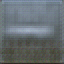

In [306]:
from PIL import Image

def to_image(inp):
    t = transforms.ToPILImage()
    return t(inp.view(3, 64, 64))


img_num = 200

'''
NOTE TO SELF:

* Make sure are using trained model for testing so you don't waste 5 hrs of your
  life again wondering why model is spitting out random noise and realize you're
  an idiot
'''

vae.eval()
out, mu, log_sigma = vae(train_[img_num][0].view(1, 3, 64, 64).to('cuda'))

img = to_image(out)
img

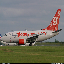

In [307]:
to_image(train[img_num][0])

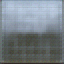

In [277]:
z = get_sample(mu, log_sigma)
dec = vae.dec
out = dec(z)
img = to_image(out)
img

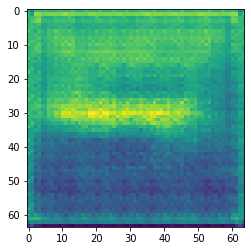

In [267]:
plt.imshow(out[0][0].cpu().detach().numpy())